In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('data_cars_BMW_clean.csv')
df

,price,used,milage,transmission,colour,engine_capacity,horsepower,fuel_type,tax,state,year
0,6940000,1,82040,автоматическая,синий,3.0,249,Дизель,18675,Не требует ремонта,2019
1,15490000,0,15,автоматическая,чёрный,3.0,381,Бензин,57150,Не требует ремонта,2023
2,7700000,1,44140,автоматическая,чёрный,2.0,231,Дизель,17325,Не требует ремонта,2021
3,13990000,0,18,автоматическая,чёрный,3.0,298,Дизель,44700,Не требует ремонта,2023
4,8990000,1,62000,автоматическая,серый,3.0,249,Дизель,18675,Не требует ремонта,2021
...,...,...,...,...,...,...,...,...,...,...,...
819,1650000,1,200000,автоматическая,белый,3.0,272,Бензин,40800,Не требует ремонта,2008
820,630000,1,250000,автоматическая,золотистый,3.0,231,"Бензин, газобаллонное оборудование",17325,Не требует ремонта,2002
821,7500000,1,94000,автоматическая,синий,3.0,249,Дизель,18675,Не требует ремонта,2020
822,1490000,1,199800,автоматическая,чёрный,3.0,272,Бензин,40800,Не требует ремонта,2007


In [3]:
df['state'].value_counts()

state
Не требует ремонта    824
Name: count, dtype: int64

# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            824 non-null    int64  
 1   used             824 non-null    int64  
 2   milage           824 non-null    int64  
 3   transmission     824 non-null    object 
 4   colour           824 non-null    object 
 5   engine_capacity  824 non-null    float64
 6   horsepower       824 non-null    int64  
 7   fuel_type        824 non-null    object 
 8   tax              824 non-null    int64  
 9   state            824 non-null    object 
 10  year             824 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 70.9+ KB


In [5]:
if(df.isnull().values.any() == False):
    print("No NaNs in the data")

No NaNs in the data


In [6]:
df.dtypes

price                int64
used                 int64
milage               int64
transmission        object
colour              object
engine_capacity    float64
horsepower           int64
fuel_type           object
tax                  int64
state               object
year                 int64
dtype: object

In [7]:
df['fuel_type'].value_counts()

fuel_type
Дизель                                558
Бензин                                262
Бензин, газобаллонное оборудование      3
Гибрид                                  1
Name: count, dtype: int64

In [8]:
df['transmission'].value_counts()

transmission
автоматическая    822
механическая        2
Name: count, dtype: int64

In [9]:
df['used'].value_counts()

used
1    773
0     51
Name: count, dtype: int64

In [10]:
df['colour'].value_counts()

colour
чёрный         385
белый          163
серый          131
синий           68
коричневый      34
серебристый     24
зелёный          7
красный          4
золотистый       3
бежевый          3
пурпурный        2
Name: count, dtype: int64

In [11]:
df['state'].value_counts()

state
Не требует ремонта    824
Name: count, dtype: int64

In [12]:
df.drop(['transmission', 'state'], inplace=True, axis=1)

In [13]:
fuel_types_to_remove = ['Бензин, газобаллонное оборудование', 'Гибрид']
df = df[~df['fuel_type'].isin(fuel_types_to_remove)]
df.reset_index(drop=True, inplace=True)
df

,price,used,milage,colour,engine_capacity,horsepower,fuel_type,tax,year
0,6940000,1,82040,синий,3.0,249,Дизель,18675,2019
1,15490000,0,15,чёрный,3.0,381,Бензин,57150,2023
2,7700000,1,44140,чёрный,2.0,231,Дизель,17325,2021
3,13990000,0,18,чёрный,3.0,298,Дизель,44700,2023
4,8990000,1,62000,серый,3.0,249,Дизель,18675,2021
...,...,...,...,...,...,...,...,...,...
815,6900000,1,150000,чёрный,3.0,400,Дизель,60000,2018
816,1650000,1,200000,белый,3.0,272,Бензин,40800,2008
817,7500000,1,94000,синий,3.0,249,Дизель,18675,2020
818,1490000,1,199800,чёрный,3.0,272,Бензин,40800,2007


In [14]:
if df.duplicated().sum() > 0:
  df1 = df.drop_duplicates().reset_index(drop=True)

df1.duplicated().sum()

0

In [15]:
df1 = df1[df1['price'] >= 0]

In [16]:
df1.describe()

,price,used,milage,engine_capacity,horsepower,tax,year
count,6.290000e+02,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,5.689595e+06,0.934817,140516.219396,3.064547,294.399046,37382.751987,2015.441971
std,3.850808e+06,0.247045,101503.427729,0.427031,60.729861,16607.763019,5.632189
min,6.000000e+05,0.000000,1.000000,2.000000,184.000000,9200.000000,1999.000000
25%,2.430000e+06,1.000000,64977.000000,3.000000,249.000000,18675.000000,2011.000000
50%,4.500000e+06,1.000000,124000.000000,3.000000,286.000000,42900.000000,2017.000000
75%,7.800000e+06,1.000000,203405.000000,3.000000,340.000000,51000.000000,2020.000000
max,2.120000e+07,1.000000,638000.000000,4.800000,530.000000,79500.000000,2024.000000


<Axes: >

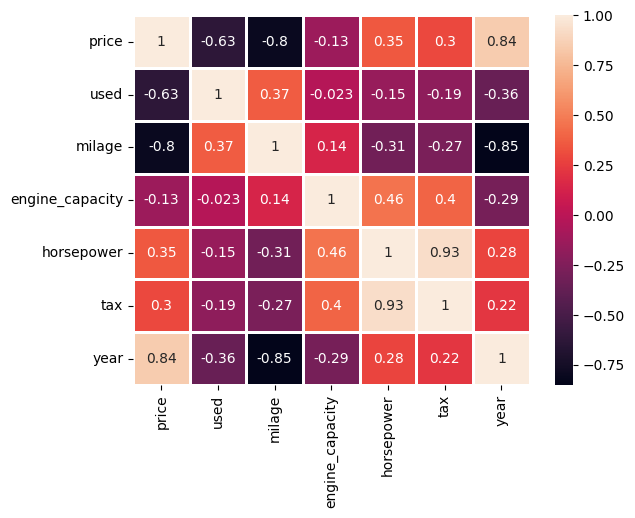

In [17]:
numeric_df = df1.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True, linewidth=1)

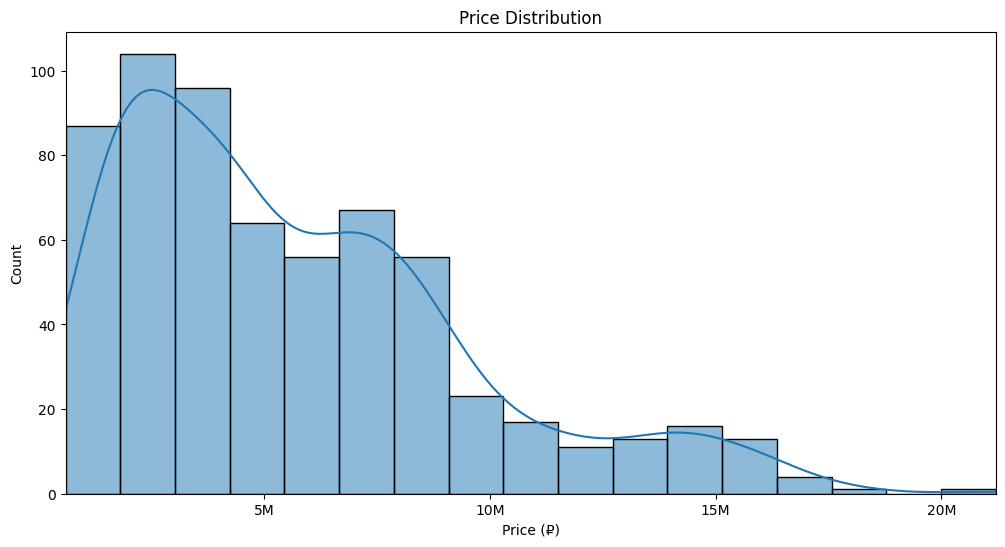

In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(df1['price'], kde = True)
plt.title('Price Distribution')
labels = ['{:.0f}'.format(x) + 'M' for x in plt.xticks()[0]/1e6]
plt.xticks(plt.xticks()[0], labels)
plt.xlabel('Price (₽)')
plt.xlim([df1['price'].min(), df1['price'].max()])
plt.show()

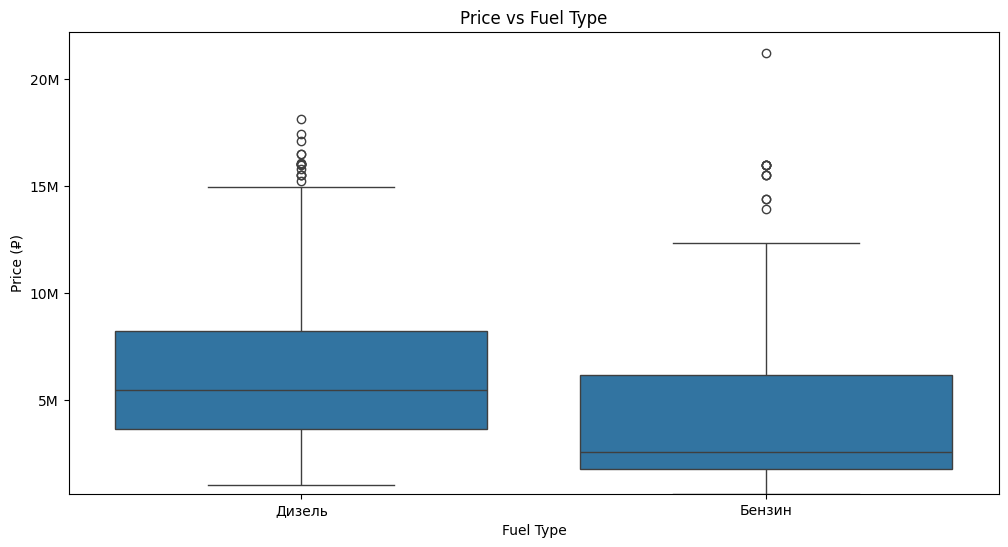

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='fuel_type', y='price', data=df)
plt.title('Price vs Fuel Type')
labels = ['{:.0f}'.format(x) + 'M' for x in plt.yticks()[0]/1e6]
plt.yticks(plt.yticks()[0], labels)
plt.ylabel('Price (₽)')
plt.xlabel('Fuel Type')
plt.ylim([df1['price'].min(), df1['price'].max()+1000000])
plt.show()

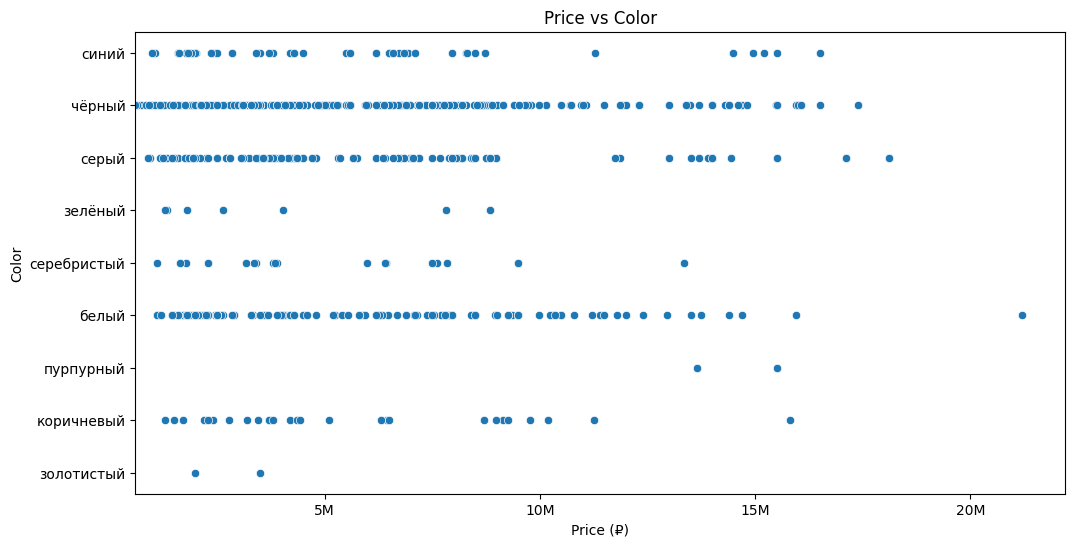

In [20]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=df1['price'], y=df['colour'])
labels = ['{:.0f}'.format(x) + 'M' for x in plt.xticks()[0]/1e6]
plt.xticks(plt.xticks()[0], labels)
plt.title('Price vs Color')
plt.ylabel('Color')
plt.xlabel('Price (₽)')
plt.xlim([df1['price'].min(), df1['price'].max()+1000000])
plt.show()

In [21]:
df1 = pd.get_dummies(df, columns=['fuel_type', 'colour'], drop_first=True)

# Model specification, regressions

In [22]:
y, X = dmatrices('price ~ used+milage+engine_capacity+horsepower', data=df1, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,73.273170,Intercept
1,1.162101,used
2,1.389821,milage
3,1.486004,engine_capacity
4,1.626769,horsepower


In [23]:
df1 = df1.drop(['year', 'tax'], axis=1)

In [24]:
df_selected = ['fuel_type_Дизель', 'colour_белый', 'colour_зелёный', 'colour_золотистый', 'colour_коричневый', 'colour_красный', 'colour_пурпурный', 'colour_серебристый', 'colour_серый', 'colour_синий', 'colour_чёрный']
for col in df_selected:
    df1[col] = df1[col].replace({True: 1, False: 0})
display(df1)

,price,used,milage,engine_capacity,horsepower,fuel_type_Дизель,colour_белый,colour_зелёный,colour_золотистый,colour_коричневый,colour_красный,colour_пурпурный,colour_серебристый,colour_серый,colour_синий,colour_чёрный
0,6940000,1,82040,3.0,249,1,0,0,0,0,0,0,0,0,1,0
1,15490000,0,15,3.0,381,0,0,0,0,0,0,0,0,0,0,1
2,7700000,1,44140,2.0,231,1,0,0,0,0,0,0,0,0,0,1
3,13990000,0,18,3.0,298,1,0,0,0,0,0,0,0,0,0,1
4,8990000,1,62000,3.0,249,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,6900000,1,150000,3.0,400,1,0,0,0,0,0,0,0,0,0,1
816,1650000,1,200000,3.0,272,0,1,0,0,0,0,0,0,0,0,0
817,7500000,1,94000,3.0,249,1,0,0,0,0,0,0,0,0,1,0
818,1490000,1,199800,3.0,272,0,0,0,0,0,0,0,0,0,0,1


In [25]:
X = df1.drop('price', axis=1)
y = df1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## OLS

In [26]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     208.5
Date:                Fri, 17 May 2024   Prob (F-statistic):          1.50e-234
Time:                        19:31:09   Log-Likelihood:                -10296.
No. Observations:                 656   AIC:                         2.062e+04
Df Residuals:                     640   BIC:                         2.070e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.733e+07   1.72

In [27]:
import statsmodels.stats.diagnostic as dg

reset = dg.linear_reset(results, power=3, test_type= 'fitted', use_f=True)

print ('== Correct Functional Form Ramsey-RESET Test ==')
print ('')
print ('Ramsey-RESET Test F-Statistic:', np.round (reset.fvalue, 6))
print ('Ramsey-RESET Test P-Value:', np.round (reset.pvalue, 6))

== Correct Functional Form Ramsey-RESET Test ==

Ramsey-RESET Test F-Statistic: 4210.581152
Ramsey-RESET Test P-Value: 0.0


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


## Heteroskedasticity Test

In [28]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

bp_test = het_breuschpagan(results.resid, results.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
bp_test_results = dict(zip(labels, bp_test))
for label, value in bp_test_results.items():
    print(f'{label}: {value}')

LM Statistic: 21.3524340707909
LM-Test p-value: 0.12594180802620586
F-Statistic: 1.4355009550639806
F-Test p-value: 0.12475825862131372


In [32]:
residuals = results.resid
abs_residuals = np.abs(residuals)

model_glejser = sm.OLS(abs_residuals, results.model.exog)
results_glejser = model_glejser.fit()

print(results_glejser.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2.393
Date:                Fri, 17 May 2024   Prob (F-statistic):            0.00225
Time:                        19:33:44   Log-Likelihood:                -9984.8
No. Observations:                 656   AIC:                         2.000e+04
Df Residuals:                     640   BIC:                         2.007e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9573.3180   1.07e+06      0.009      0.9

In [30]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     46.82
Date:                Fri, 17 May 2024   Prob (F-statistic):           2.71e-88
Time:                        19:31:10   Log-Likelihood:                -10296.
No. Observations:                 656   AIC:                         2.062e+04
Df Residuals:                     640   BIC:                         2.070e+04
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.733e+07    1.1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '
